# Import libraries

In [1]:
# Read files
import os

# Data wrangling and data visualisation 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix

# Others
import time
import warnings
warnings.filterwarnings("ignore")

# Import and read data

In [2]:
# Print files in current working directory 
os.chdir("H:\DM2021")
#os.listdir(os.curdir)

In [3]:
#url = "https://storage.googleapis.com/2017_ithome_ironman/data/kaggle_titanic_train.csv"
#titanic_train = pd.read_csv(url)
data = pd.read_csv("train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Feature engineering and preprocessing
- Fill missing data in the **Age** column with average age
- Combine **SibSp** and **Parch** features into a single feature: **family_size**
- Create indicator for missing data in the **Cabin** column: **cabin_missing**
- Encode the **Sex** column by assigning 0: male and 1: female
- Drop **SibSp**, **Parch**, **PassengerId**, **Cabin**, **Embarked**, **Name** and **Ticket** columns 
- Train test split (80% training set and 20% test set)

In [4]:
# Missing data 
total = len(data)
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data
pd.DataFrame({"# Missing": missing_data, "% Missing": round(missing_data / len(data) * 100, 2)})

,# Missing,% Missing
Age,177,19.87
Cabin,687,77.10
Embarked,2,0.22


In [5]:
# Fill missing data in Age column
data['Age'].fillna(data['Age'].mean(), inplace = True)

<Figure size 432x288 with 0 Axes>

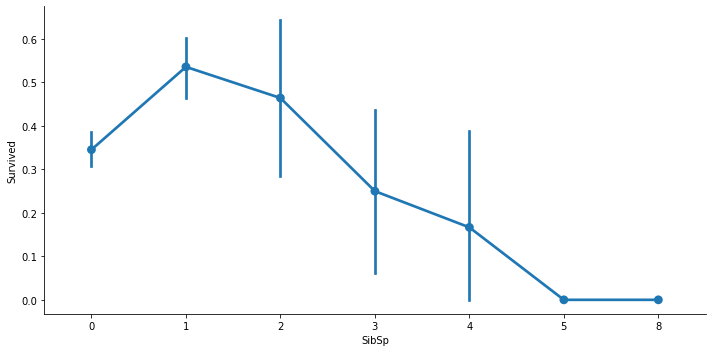

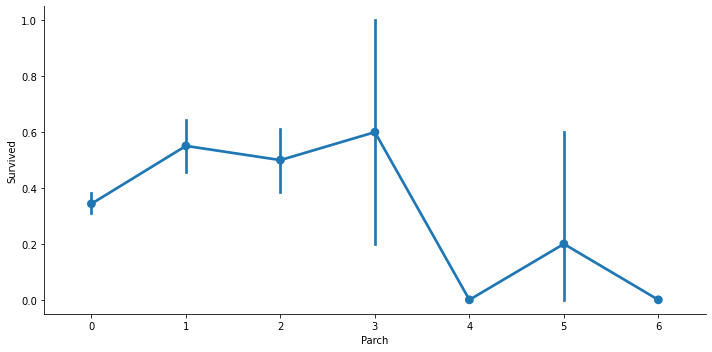

In [6]:
# Survival probability by SibSp and Parch 
for i, col in enumerate(['SibSp', 'Parch']):
    plt.figure(i)
    sns.catplot(x = col, y = 'Survived', data = data, kind = 'point', aspect = 2)

Since both features have similar effect and trajectory on survival probability, let's combine these features into a single feature. 

In [7]:
# Combine SibSp and Parch into a single feature family_size 
data['family_size'] = data['SibSp'] + data['Parch']
data[['SibSp', 'Parch', 'family_size']].head(10)

,SibSp,Parch,family_size
0,1,0,1
1,1,0,1
2,0,0,0
3,1,0,1
4,0,0,0
5,0,0,0
6,0,0,0
7,3,1,4
8,0,2,2
9,1,0,1


To prevent multicollinearity issues, we need to remove SibSp and Parch features. 

In [8]:
# Drop SibSp, Parch and PassengerId features
data = data.drop(['SibSp', 'Parch', 'PassengerId'], axis = 1)
data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family_size
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0


In [10]:
# Survival probability by missing cabin
data.groupby(data['Cabin'].isnull())['Survived'].mean()

Cabin
False    0.666667
True     0.299854
Name: Survived, dtype: float64

Passengers without cabin have significantly lower probability of surviving the Titanic. Therefore, we should create an missing cabin indicator in order to capture this relationship. 

In [11]:
# 1: Cabin is missing, 0: Cabin is not missing 
data['cabin_missing'] = np.where(data['Cabin'].isnull(), 1, 0)
data[['Cabin', 'cabin_missing']].head()

,Cabin,cabin_missing
0,NaN,1
1,C85,0
2,NaN,1
3,C123,0
4,NaN,1


In [12]:
# Encode Sex 0: male, 1: female
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family_size,cabin_missing
0,0,3,"Braund, Mr. Owen Harris",0,22.0,A/5 21171,7.2500,NaN,S,1,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,PC 17599,71.2833,C85,C,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,113803,53.1000,C123,S,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,373450,8.0500,NaN,S,0,1


In [13]:
# Drop Cabin, Embarked, Name and Ticket columns
data = data.drop(['Cabin', 'Embarked', 'Name', 'Ticket'], axis = 1)
data.head()

,Survived,Pclass,Sex,Age,Fare,family_size,cabin_missing
0,0,3,0,22.0,7.2500,1,1
1,1,1,1,38.0,71.2833,1,0
2,1,3,1,26.0,7.9250,0,1
3,1,1,1,35.0,53.1000,1,0
4,0,3,0,35.0,8.0500,0,1


In [14]:
# Separate features and target variables
features = data.drop('Survived', axis = 1)
target = data['Survived']

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

# Check shape (rows, columns)
print(f"Original data: {data.shape}")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

Original data: (891, 7)
X_train: (712, 6)
Y_train: (712,)
X_test: (179, 6)
Y_test: (179,)


Our training and test set are now ready for modelling.

# Random forest

In [15]:
# Default hyperparameters for RandomForestClassifier 
print(RandomForestClassifier())

RandomForestClassifier()


In [16]:
# GridSearchCV for RandomForestClassifier
rf = RandomForestClassifier(n_jobs = -1, random_state = 10)
params = {
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, params, cv = 5, n_jobs = -1)
cv.fit(X_train, Y_train)
pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.104841,0.010953,0.030877,0.008809,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.832168,0.846154,0.816901,0.802817,0.845070,0.828622,0.016696,1
6,0.019189,0.003300,0.008889,0.002424,8,5,"{'max_depth': 8, 'n_estimators': 5}",0.818182,0.839161,0.802817,0.838028,0.823944,0.824426,0.013478,2
7,0.105253,0.007323,0.017779,0.002034,8,50,"{'max_depth': 8, 'n_estimators': 50}",0.832168,0.825175,0.795775,0.816901,0.845070,0.823018,0.016458,3
8,0.606601,0.117843,0.058196,0.007310,8,250,"{'max_depth': 8, 'n_estimators': 250}",0.825175,0.825175,0.802817,0.809859,0.830986,0.818802,0.010632,4
10,0.134270,0.030568,0.021309,0.001332,16,50,"{'max_depth': 16, 'n_estimators': 50}",0.825175,0.797203,0.795775,0.823944,0.838028,0.816025,0.016703,5


In [17]:
# Best hyperparameters for RandomForestClassifier 
cv.best_params_

{'max_depth': 4, 'n_estimators': 50}

In [18]:
# Instantiate RandomForestClassifier with best hyperparameters 
rf = RandomForestClassifier(n_estimators = 50, max_depth = 4, n_jobs = -1, random_state = 42)

# Fit model
start = time.time()
rf_model = rf.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = end - start

# Time and prediction results
precision, recall, fscore, support = score(Y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

Fit time: 0.062 / Predict time: 0.01
Precision: 0.797 / Recall: 0.689 / Accuracy: 0.799


<AxesSubplot:>

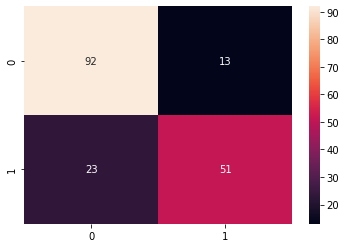

In [20]:
# Confusion matrix for RandomForestClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

# Gradient boosting

In [19]:
# Default hyperparameters for GradientBoostingClassifier
print(GradientBoostingClassifier())

GradientBoostingClassifier()


In [20]:
# GridSearchCV for GradientBoostingClassifier 
gb = GradientBoostingClassifier(random_state = 10)
params = {
    'n_estimators': [5, 50, 250, 500],
    'max_depth': [1, 3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}

cv = GridSearchCV(gb, params, cv = 5, n_jobs = -1)
cv.fit(X_train, Y_train)
pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.241463,0.010280,0.003192,1.163048e-03,0.01,3,250,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.846154,0.839161,0.823944,0.816901,0.802817,0.825795,0.015515,1
10,0.442835,0.013515,0.003989,1.994538e-03,0.01,5,250,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.839161,0.825175,0.802817,0.830986,0.823944,0.824416,0.012066,2
11,0.868216,0.009555,0.004189,3.990651e-04,0.01,5,500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.832168,0.832168,0.788732,0.830986,0.838028,0.824416,0.018011,3
7,0.454405,0.013116,0.002991,2.234530e-06,0.01,3,500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.832168,0.839161,0.823944,0.816901,0.802817,0.822998,0.012575,4
26,0.240567,0.011622,0.001994,4.156970e-07,0.1,3,250,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.811189,0.825175,0.802817,0.838028,0.830986,0.821639,0.012899,5


In [21]:
# Best hyperparameters for GradientBoostingClassifier 
cv.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}

In [22]:
# Instantiate GradientBoostingClassifier with best hyperparameters 
rf = GradientBoostingClassifier(n_estimators = 250, max_depth = 3, learning_rate = 0.01, random_state = 42)

# Fit model
start = time.time()
rf_model = rf.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = end - start

# Time and prediction results
precision, recall, fscore, support = score(Y_test, Y_pred, average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

Fit time: 0.17 / Predict time: 0.002
Precision: 0.812 / Recall: 0.703 / Accuracy: 0.81


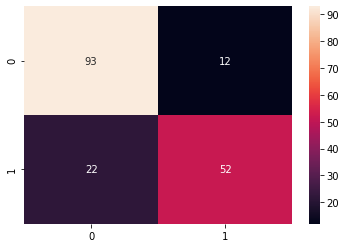

In [23]:
# Confusion matrix for GradientBoostingClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')